In [1]:
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt
import glob
from align_dlib import * #downloaded from openface github repo
from infer import *

# get the predictor-file from here: https://github.com/davisking/dlib-models/blob/master/shape_predictor_68_face_landmarks.dat.bz2
aligner = AlignDlib("shape_predictor_68_face_landmarks.dat")

In [2]:
# extracted_patches contains detected faces (by opencv2) in different sizes and as jpg
face_patches_filenames = glob.glob("./extracted_patches/*.jpg")
print("Got %d face-patches" % (len(face_patches_filenames)))

pred = Predictor()

Got 5431 face-patches


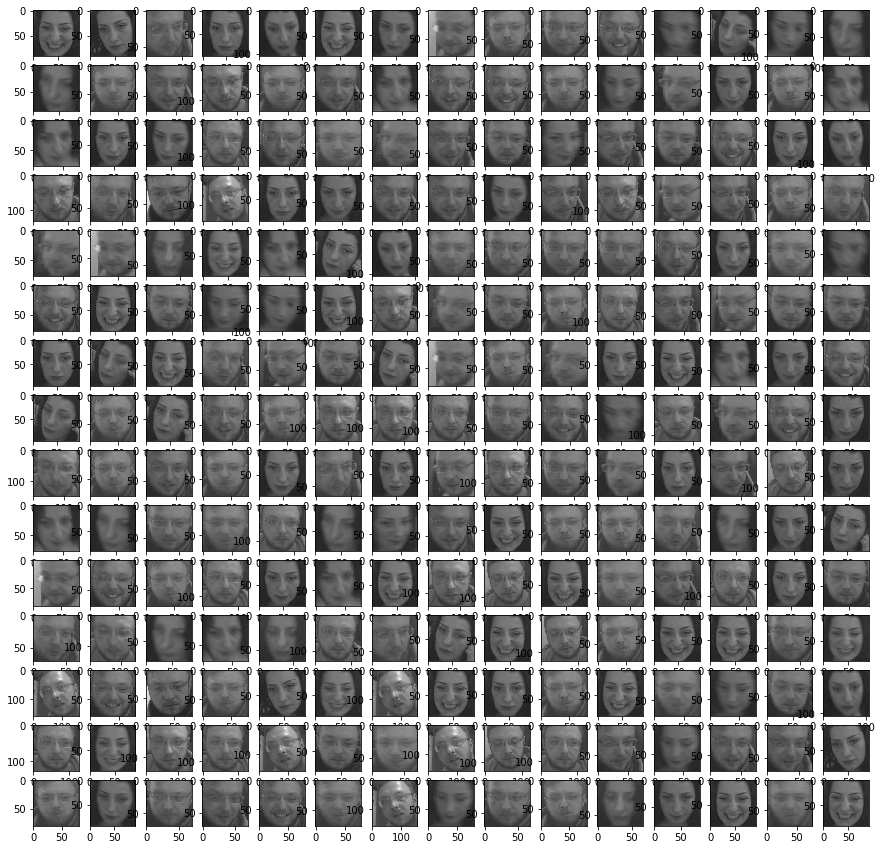

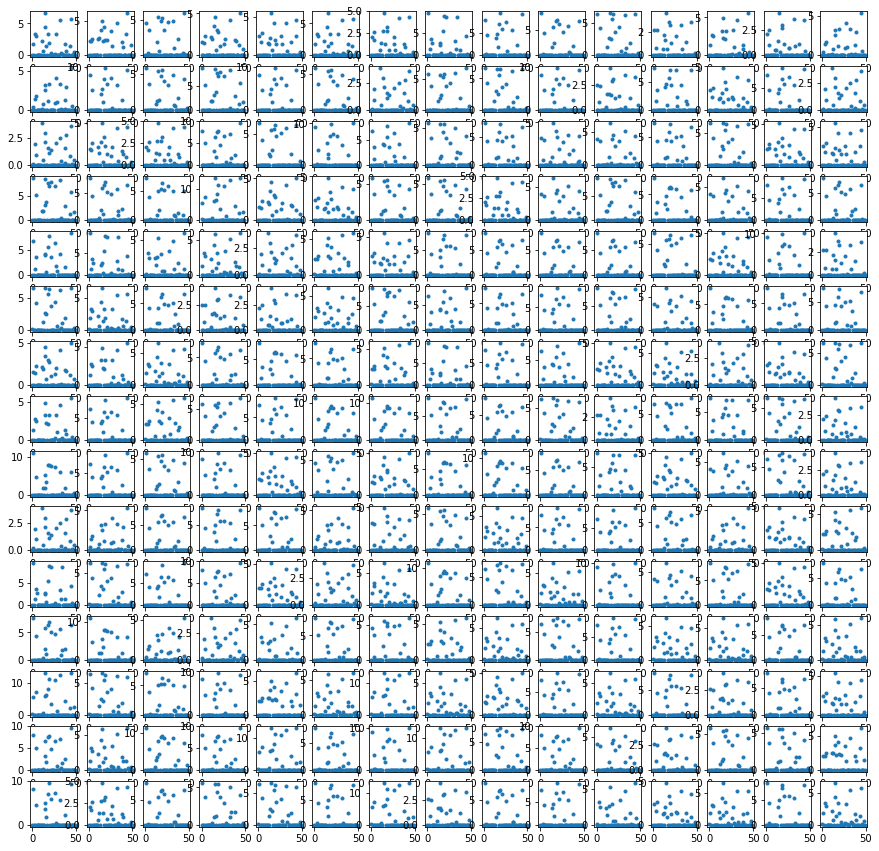

In [88]:
# select some random patches and plot them
num_imgs = 225 # select a square as this number
rows,cols = np.sqrt(num_imgs),np.sqrt(num_imgs)

images = []
representations = []

fig2 = plt.figure(0,figsize=(15,15)) # contains image patches
fig = plt.figure(1,figsize=(15,15))  # contains representations as numerical-value-plots

for idx in range(num_imgs):
    fig.add_subplot(rows,cols,idx+1)
    while True:
        img = cv2.imread(face_patches_filenames[np.random.randint(len(face_patches_filenames))])
        try:
            # this is the face-alignment-code of openface.
            # it is not used atm, but because the OPENCV-facedetector also
            # saves uniform patches, we first use this function to check
            # whether the alignment-code (dlib) detects facial landmarks
            face_test = aligner.align(64,img)
            aligned_img = img
            if face_test is not None:
                images.append(aligned_img) #append for later plotting
                # FIXME: this is dirty -> directly insert the data into the predictor
                # if we preprocess later this is gonna get messy really quick
                pred.patches = np.array([cv2.resize(aligned_img[:,:,0]/255.,(32,32))]).astype(np.float32)
                # get the values of the models forward-pass
                logs,out1,out2,out3,out4,out5 = pred.pred()
                
                # plot the representation
                plt.figure(1)
                fig2.add_subplot(rows,cols,idx+1)
                out4 = out4.data.numpy()
                representations.append(out4[0])
                
                # plot the image-patch
                plt.plot(range(out4.shape[1]), out4[0],'.')
                plt.figure(0)
                plt.imshow(aligned_img)
                break
        except Exception as e:
            print(e)
plt.show()

(225, 50)
[0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 0 0 0 1 1 1 1
 1 1 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 1
 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 1 1
 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 1 0
 0 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 0 0 1 0 1 1 1 1 0
 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0
 0 1 0]


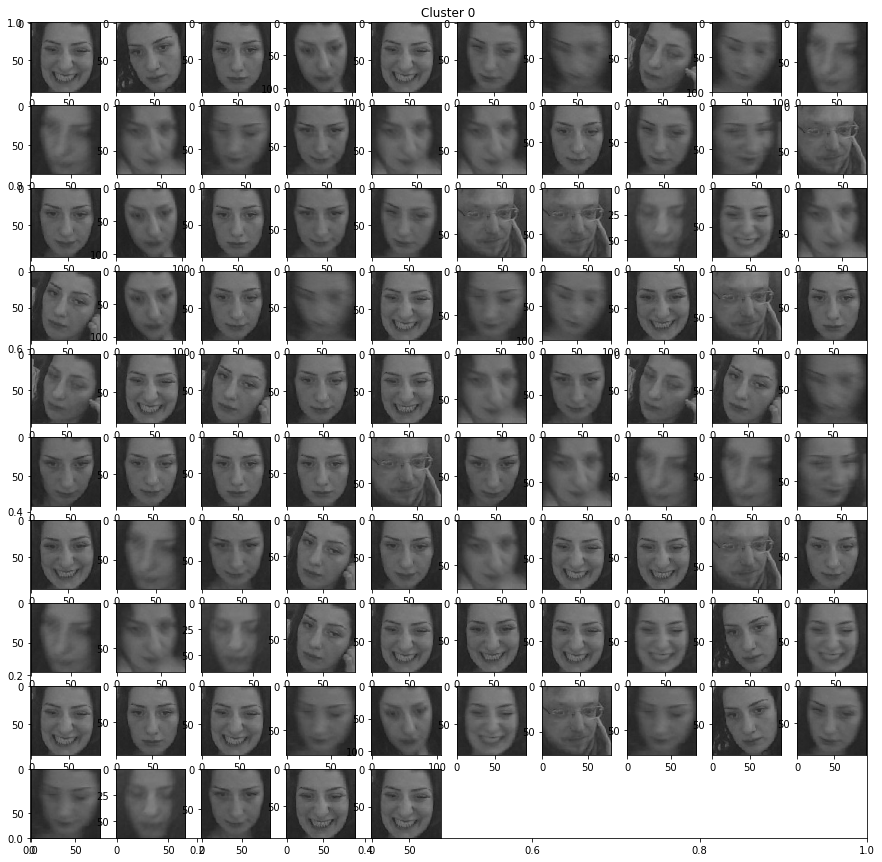

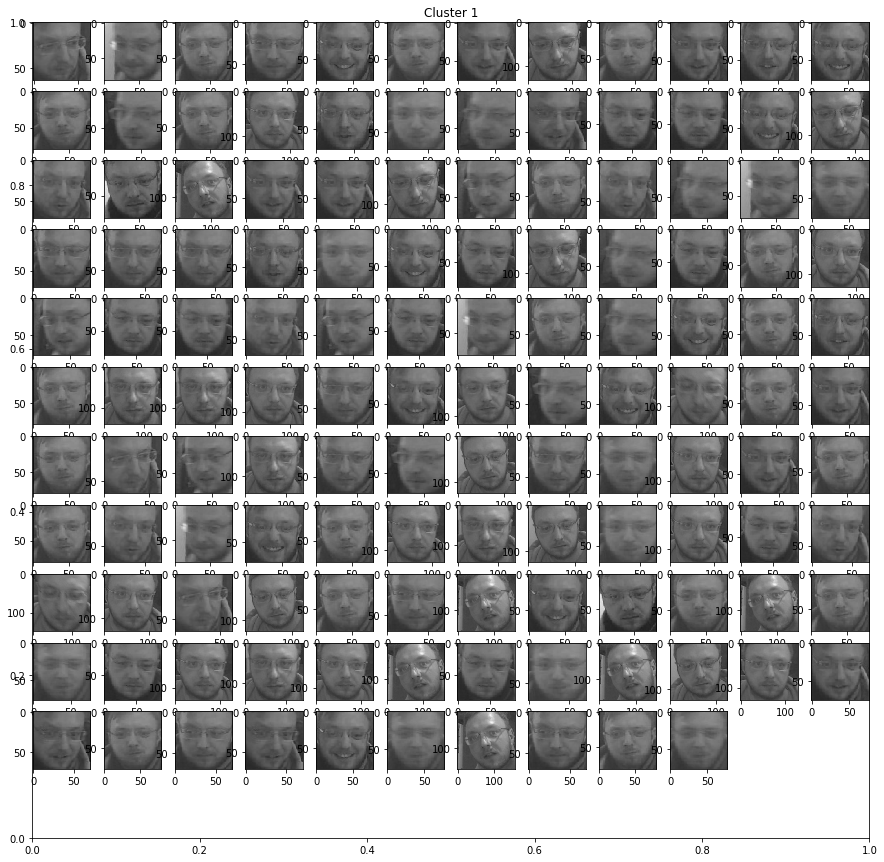

In [89]:
representations= np.array(representations)
# learn a clustering on the representations
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(representations)
print kmeans

for cc in np.unique(kmeans):
    fig = plt.figure(figsize=(15,15))
    plt.title("Cluster %d" % (cc))
    num = kmeans[kmeans == cc].shape[0]
    
    rows = np.sqrt(num) + 1
    cnt = 0
    for idx,c in enumerate(kmeans):
        if c == cc:
            cnt += 1
            fig.add_subplot(rows,rows,cnt)
            plt.imshow(images[idx])
plt.show()

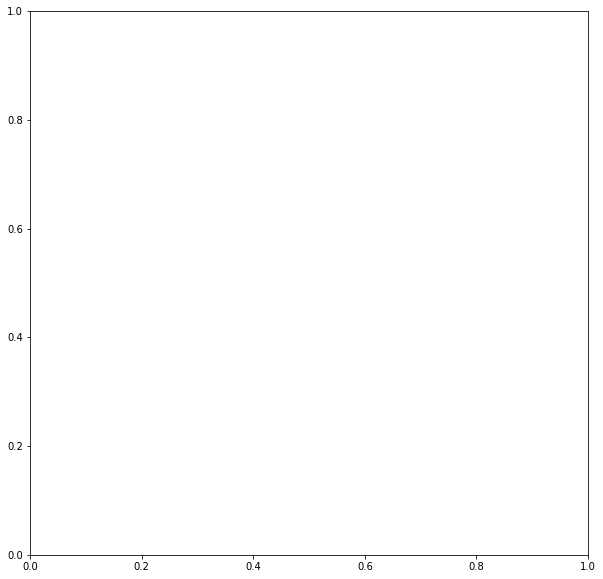

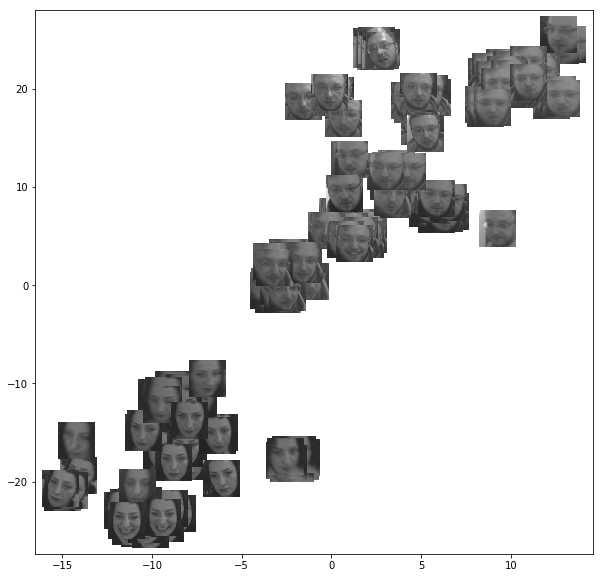

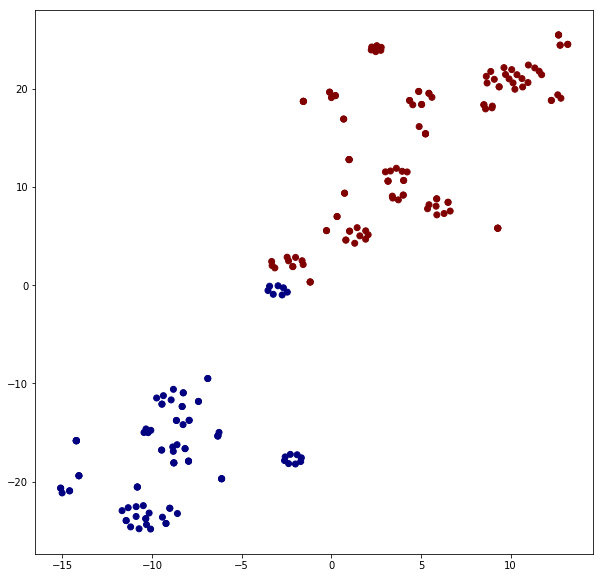

In [100]:
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
X_embedded = TSNE(n_components=2).fit_transform(representations)

# plot embedding with image patches
fig,ax = plt.subplots(figsize=(10,10))
for idx,embed in enumerate(X_embedded):
    oi = OffsetImage(cv2.resize(images[idx],(246,246)), zoom = 0.15)
    box = AnnotationBbox(oi, (embed[0], embed[1]), frameon=False)
    ax.add_artist(box)
ax.plot(X_embedded[:,0], X_embedded[:,1], '.')
plt.show()

# plot embedding with colors (recognize overlaps better)
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(X_embedded[:,0], X_embedded[:,1], c=kmeans, cmap='jet')
plt.show()
